I made this kernel for generating masks using deep learning. I was inspired by the discussion in this thread: https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression/discussion/166123

Using a pre-trained model, we can get a lung mask pretty easily. Let's check this out: 

In [ ]:
#! pip install git+https://github.com/SoufianeDataFan/lungmask

In [4]:
from os import listdir, mkdir
import numpy as np
import pandas as pd
import pydicom
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import skimage
from skimage.measure import label,regionprops
from skimage.segmentation import clear_border
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm
import cv2
import math
#Interaction user
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from IPython.display import HTML
from IPython.display import clear_output
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
def selectDicom(x=6):
    print("El Dicom Escogido es: {}".format(x))
    return x
def selectPatient(x=0):
    print("Selected Patient: {}".format(x))
    return x
def selectSeries(x=0):
    print("Selected Serie: {}".format(x))
    return x
def selectDirectory(x="./"):
    print("Selected Directory: {}".format(x))
    return x

In [3]:
widgetSelDirectory = interactive(selectDirectory, x=["CD_2_CLEAN","CD_1_CLEAN"])
display(widgetSelDirectory)

interactive(children=(Dropdown(description='x', options=('CD_2_CLEAN', 'CD_1_CLEAN'), value='CD_2_CLEAN'), Out…

In [4]:
basepathAqp = "../../datasetAqp/"+widgetSelDirectory.result
listEstudios = listdir(basepathAqp)

In [5]:
datasetAqp = pd.DataFrame(listEstudios, columns=["Estudio"])

In [6]:
estudios = []
for estudio in listEstudios:
    estudios.append(basepathAqp + "/"+estudio)

In [7]:
datasetAqp['fullPath'] = estudios
datasetAqp = datasetAqp.sort_values(by="Estudio", ascending=True, key=lambda col: col.str[5:],ignore_index = True)

In [8]:
datasetAqp

,Estudio,fullPath
0,COD0021,../../datasetAqp/CD_2_CLEAN/COD0021
1,COD0022,../../datasetAqp/CD_2_CLEAN/COD0022
2,COD0023,../../datasetAqp/CD_2_CLEAN/COD0023
3,COD0024,../../datasetAqp/CD_2_CLEAN/COD0024
4,COD0025,../../datasetAqp/CD_2_CLEAN/COD0025
5,COD0026,../../datasetAqp/CD_2_CLEAN/COD0026
6,COD0027,../../datasetAqp/CD_2_CLEAN/COD0027
7,COD0028,../../datasetAqp/CD_2_CLEAN/COD0028
8,COD0029,../../datasetAqp/CD_2_CLEAN/COD0029
9,COD0030,../../datasetAqp/CD_2_CLEAN/COD0030


In [9]:
slices = []
def load_scans(dcm_path,stringInit):
    if stringInit  == "I":
        #ordenar por nro de orden del archivo -> porque no hay ImagePosition metadata por cual podriamos filtrar
        files = listdir(dcm_path)
        file_nums = [np.int(file.split(".")[0][1:]) for file  in files]
        sorted_file_nums = np.sort(file_nums)[::-1]
        
        #cortes ordenados y leidos se debe agregar un I al inicio del corte dicom (ojo no lleva extension .dcm)
        for file_num in tqdm(sorted_file_nums):
            if (file_num == 0):
                slices.append(pydicom.dcmread(dcm_path + "/I" + str(file_num) ))
            elif (int(math.log10(file_num))+1 == 1):
                slices.append(pydicom.dcmread(dcm_path + "/I" + str(file_num) ))
            else:
                slices.append(pydicom.dcmread(dcm_path + "/I" + str(file_num) ))
    elif stringInit == "Z":
        #ordenar por nro de orden del archivo -> porque no hay ImagePosition metadata por cual podriamos filtrar
        files = listdir(dcm_path)
        file_nums = [np.int(file.split(".")[0][1:]) for file  in files]
        sorted_file_nums = np.sort(file_nums)[::-1]
        #cortes ordenados y leidos se debe agregar un I al inicio del corte dicom (ojo no lleva extension .dcm)
        for file_num in tqdm(sorted_file_nums):
            if int(math.log10(file_num))+1 == 1:
                slices.append(pydicom.dcmread(dcm_path + "/Z0" + str(file_num)))
            else:
                slices.append(pydicom.dcmread(dcm_path + "/Z" + str(file_num)))
    return slices

#### Widget Control Parameters

In [10]:
widgetSelectionDicom = interactive(selectDicom,x=(0,20))
display(widgetSelectionDicom)

interactive(children=(IntSlider(value=6, description='x', max=20), Output()), _dom_classes=('widget-interact',…

In [11]:
#muestra de un estudio dado
example = datasetAqp.fullPath.values[widgetSelectionDicom.result]
scans = load_scans(example,"I")
print("El estudio contiene {} cortes".format(len(scans)))

100%|██████████| 280/280 [00:05<00:00, 49.61it/s]

El estudio contiene 280 cortes


In [12]:
estudio_sel = example[28:]
estudio_sel

'COD0021'

In [13]:
df = pd.DataFrame(columns=["PatientID","StudyDescription","SeriesNumber","SeriesDescription","InstanceNumber","SeriesInstanceUID"])
#df = pd.DataFrame(columns=["PatientID"])
for scan in tqdm(scans):
    #serie
    dicSerie = {"PatientID":scan.PatientID,
                "StudyDescription":scan.StudyDescription,
                "SeriesNumber":scan.SeriesNumber,
                "SeriesDescription":scan.SeriesDescription,
                "InstanceNumber":scan.InstanceNumber,
                "SeriesInstanceUID":scan.SeriesInstanceUID
               }
    df = df.append(dicSerie, ignore_index=True)

100%|██████████| 280/280 [00:01<00:00, 221.81it/s]


In [14]:
df

,PatientID,StudyDescription,SeriesNumber,SeriesDescription,InstanceNumber,SeriesInstanceUID
0,SINID,PULMONES S/C,404,SAG SC PUL,70,1.3.6.1.4.1.5962.99.1.3103875192.1693539311.16...
1,SINID,PULMONES S/C,404,SAG SC PUL,69,1.3.6.1.4.1.5962.99.1.3103875192.1693539311.16...
2,SINID,PULMONES S/C,404,SAG SC PUL,68,1.3.6.1.4.1.5962.99.1.3103875192.1693539311.16...
3,SINID,PULMONES S/C,404,SAG SC PUL,67,1.3.6.1.4.1.5962.99.1.3103875192.1693539311.16...
4,SINID,PULMONES S/C,404,SAG SC PUL,66,1.3.6.1.4.1.5962.99.1.3103875192.1693539311.16...
...,...,...,...,...,...,...
275,SINID,PULMONES S/C,300,AX SC,5,1.3.6.1.4.1.5962.99.1.3103875192.1693539311.16...
276,SINID,PULMONES S/C,300,AX SC,4,1.3.6.1.4.1.5962.99.1.3103875192.1693539311.16...
277,SINID,PULMONES S/C,300,AX SC,3,1.3.6.1.4.1.5962.99.1.3103875192.1693539311.16...
278,SINID,PULMONES S/C,300,AX SC,2,1.3.6.1.4.1.5962.99.1.3103875192.1693539311.16...


In [15]:
# Oonly one pacient with different type of series
listPatients = df.PatientID.unique()
listPatients

array(['SINID'], dtype=object)

In [16]:
widgetSelPatient = interactive(selectPatient, x=listPatients)
display(widgetSelPatient)

interactive(children=(Dropdown(description='x', options=('SINID',), value='SINID'), Output()), _dom_classes=('…

In [17]:
#Series List
listSeries = df[df["PatientID"]==widgetSelPatient.result]["SeriesNumber"].unique()
listSeries

array([404, 402, 400, 300], dtype=object)

In [18]:
#Description of every serie
listSeriesDescription = df[df["PatientID"]==listPatients[0]]["SeriesDescription"].unique()
listSeriesDescription

array(['SAG SC PUL', 'COR SC PUL', 'AX SC PUL', 'AX SC'], dtype=object)

In [19]:
widgetSelSerie = interactive(selectSeries, x=listSeries)
display(widgetSelSerie)

interactive(children=(Dropdown(description='x', options=(404, 402, 400, 300), value=404), Output()), _dom_clas…

In [20]:
#Select Slice AXIAL S/C PULM which is parenquimal slice
dicomAislada = df[(df["PatientID"]==widgetSelPatient.result) & (df["SeriesNumber"]==widgetSelSerie.result)]
dicomAislada

,PatientID,StudyDescription,SeriesNumber,SeriesDescription,InstanceNumber,SeriesInstanceUID
140,SINID,PULMONES S/C,400,AX SC PUL,70,1.3.6.1.4.1.5962.99.1.3103875192.1693539311.16...
141,SINID,PULMONES S/C,400,AX SC PUL,69,1.3.6.1.4.1.5962.99.1.3103875192.1693539311.16...
142,SINID,PULMONES S/C,400,AX SC PUL,68,1.3.6.1.4.1.5962.99.1.3103875192.1693539311.16...
143,SINID,PULMONES S/C,400,AX SC PUL,67,1.3.6.1.4.1.5962.99.1.3103875192.1693539311.16...
144,SINID,PULMONES S/C,400,AX SC PUL,66,1.3.6.1.4.1.5962.99.1.3103875192.1693539311.16...
...,...,...,...,...,...,...
205,SINID,PULMONES S/C,400,AX SC PUL,5,1.3.6.1.4.1.5962.99.1.3103875192.1693539311.16...
206,SINID,PULMONES S/C,400,AX SC PUL,4,1.3.6.1.4.1.5962.99.1.3103875192.1693539311.16...
207,SINID,PULMONES S/C,400,AX SC PUL,3,1.3.6.1.4.1.5962.99.1.3103875192.1693539311.16...
208,SINID,PULMONES S/C,400,AX SC PUL,2,1.3.6.1.4.1.5962.99.1.3103875192.1693539311.16...


In [21]:
serieID_select = dicomAislada["SeriesInstanceUID"][dicomAislada.index.min()]
serieID_select

'1.3.6.1.4.1.5962.99.1.3103875192.1693539311.1622306578552.76.0'

In [22]:
print("Min Número de Corte: {}".format(dicomAislada.index.min()))
print("Max Número de Corte: {}".format(dicomAislada.index.max()))

Min Número de Corte: 140
Max Número de Corte: 209


In [23]:
scansFiltrado = scans[dicomAislada.index.min():dicomAislada.index.max()+1]

In [24]:
orderScans = sorted(scansFiltrado, key=lambda corte: corte.InstanceNumber)

#### Lectura de pixels y transformacion a HU

In [25]:
#definiendo el aire con valores cero (pixeles completamente oscuros vacio)
def set_outside_scanner_to_air(raw_pixelarrays):
    #filtrando pintando todo negro el aire
    raw_pixelarrays[raw_pixelarrays <= -1000] = 0
    return raw_pixelarrays

In [26]:
#tranformar a unidades de hounsfield
def transform_to_hu(slices):
    images = np.stack([file.pixel_array for file in slices])
    #convertido a escala de grises de 16 bits
    images = images.astype(np.int16)
    #aplicar pintado de aire de todos los cortes apilados <= -1000
    images = set_outside_scanner_to_air(images)
    
    #convertirmos a HU
    for n in range(len(slices)):
        intercept = slices[n].RescaleIntercept
        slope = slices[n].RescaleSlope
        
        #FORMULA = mb + i donde m slope o pendiente e i es el intercepto
        
        #MULTIPLICAR EL SLOPE
        #solo en caso de q el slope sea 0.5, 2, 0.9 
        if slope != 1:
            #para ser multiplicado por slope debe pasarse a flotante
            images[n] = slope * images[n].astype(np.float64)
            #despues ya convertimos a la escala de grise 16 bits
            images[n] = images[n].astype(np.int16)
        
        #ADICIONAR EL INTERCEPTO
        #directamente el intercepto en caso el slope sea 1
        #trata como escala de 16 bits el intercepto
        images[n] += np.int16(intercept)
        
    return np.array(images, dtype=np.int16)

In [27]:
hu_scans = transform_to_hu(orderScans)

In [28]:
print("Total Nro de Cortes: {}".format(len(hu_scans)))

Total Nro de Cortes: 70


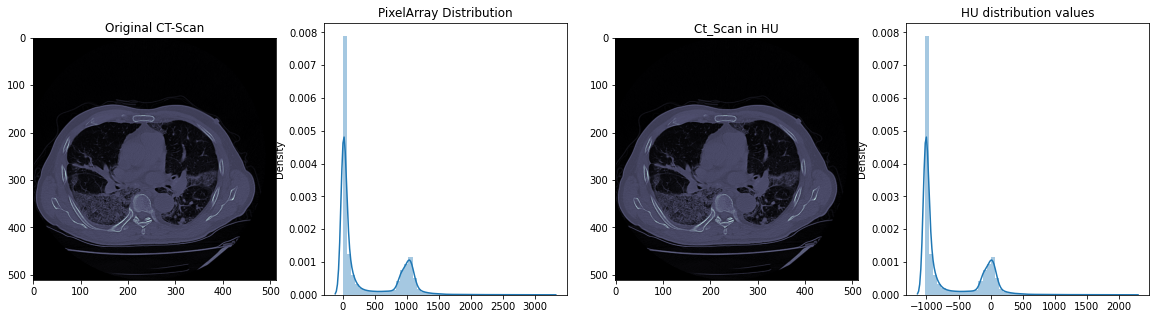

In [29]:
fix, ax =  plt.subplots(1,4,figsize=(20,5))
ax[0].set_title("Original CT-Scan")
ax[0].imshow(orderScans[30].pixel_array, cmap="bone")
ax[1].set_title("PixelArray Distribution")
sns.distplot(orderScans[30].pixel_array.flatten(),ax=ax[1])

ax[2].set_title("Ct_Scan in HU")
ax[2].imshow(hu_scans[30],cmap='bone')
ax[3].set_title("HU distribution values")
sns.distplot(hu_scans[30].flatten(), ax=ax[3])

for m in [0,2]:
    ax[m].grid(False)

In [30]:
# import matplotlib.animation as animation

# fig = plt.figure()

# ims = []
# for image in orderScans:
#     newimage = image.pixel_array
#     im = plt.imshow(newimage, animated=True, cmap="Greys")
#     plt.axis("off")
#     ims.append([im])

# ani = animation.ArtistAnimation(fig, ims, interval=100, blit=False,
#                                 repeat_delay=1000)

In [31]:
# HTML(ani.to_jshtml())

### **Original Lung CT-Scan**

In [32]:
# #Aplicar UH al dicom completo
# def get_pixels_hu(slices):
#     image = np.stack([s.pixel_array for s in slices])
#     # Convert to int16 (from sometimes int16), 
#     # should be possible as values should always be low enough (<32k)
#     image = image.astype(np.int16)

#     # Set outside-of-scan pixels to 0
#     # The intercept is usually -1024, so air is approximately 0
#     image[image == -2000] = 0
    
#     # Convert to Hounsfield units (HU)
#     for slice_number in range(len(slices)):
        
#         intercept = slices[slice_number].RescaleIntercept
#         slope = slices[slice_number].RescaleSlope
        
#         if slope != 1:
#             image[slice_number] = slope * image[slice_number].astype(np.float64)
#             image[slice_number] = image[slice_number].astype(np.int16)
            
#         image[slice_number] += np.int16(intercept)
    
#     return np.array(image, dtype=np.int16)

In [33]:
# #mascara creada a partir del intervalo de UH ya definido y con la
# #imagen ya aplicada la transformacion de UH
# def set_lungwin(img, hu=[-1200., 600.]):
#     lungwin = np.array(hu)
#     newimg = (img-lungwin[0]) / (lungwin[1]-lungwin[0])
#     newimg[newimg < 0] = 0
#     newimg[newimg > 1] = 1
#     newimg = (newimg * 255).astype('uint8')
#     return newimg

In [34]:
# scan_array = set_lungwin(get_pixels_hu(scans))

### **Mask using U-net(R231) Lung CT-Scan**

In [35]:
from lungmask import mask
import SimpleITK as sitk
import sys
import os

In [36]:
# #agregando una dimension adicional
# arrayImage = np.expand_dims(im, axis=0)
# #pasando a simple itk
# print(arrayImage.shape)
# input_image = sitk.GetImageFromArray(arrayImage)
# #volviendo a array numpy
# arrayImage = sitk.GetArrayFromImage(input_image).astype(np.int32)
# #arrayImage.shape

# z = 0
# sliceImage = sitk.GetArrayFromImage(input_image)[z,:,:,:]
# plt.imshow(sliceImage)

In [37]:
mascarasPred = []
def get_mascaras(slices_hu):
    
    for corte in tqdm(slices_hu):   
        #agregando una dimension adicional
        arrayImage = np.expand_dims(corte.astype(np.float32)  , axis=0)
        #pasando a simple itk
        input_image = sitk.GetImageFromArray(arrayImage)      
        
        mascarasPred.append(mask.apply(input_image)[0])
    return mascarasPred

In [38]:
len(orderScans)

70

In [39]:
mascaras = get_mascaras(hu_scans[::-1])

100%|██████████| 70/70 [01:44<00:00,  1.49s/it]


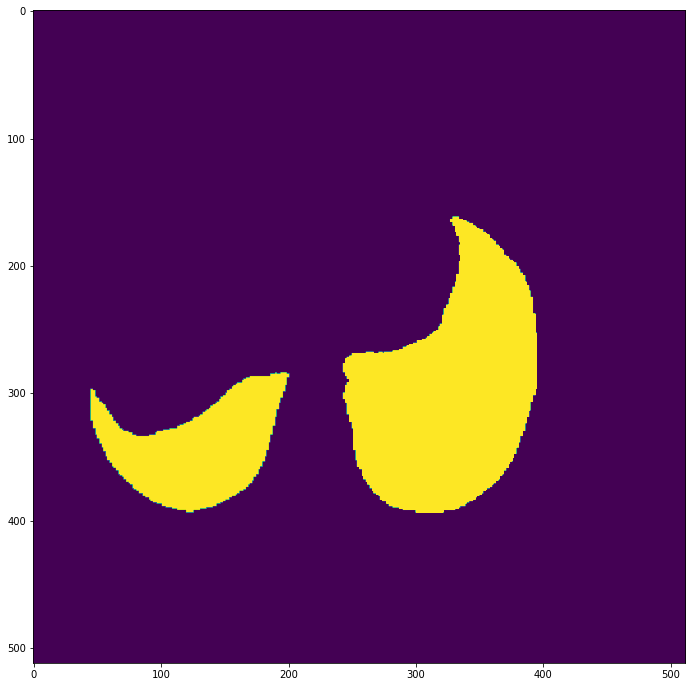

In [43]:
fig = plt.figure(figsize=(12, 12))
plt.imshow(mascaras[15],norm=colors.Normalize(0,1))

In [44]:
# import matplotlib.animation as animation

# fig = plt.figure()

# ims = []
# for image in mascaras:
#     im = plt.imshow(image, animated=True, cmap="Greys")
#     plt.axis("off")
#     ims.append([im])

# ani = animation.ArtistAnimation(fig, ims, interval=100, blit=False,
#                                 repeat_delay=1000)

In [45]:
# HTML(ani.to_jshtml())

##### Saving mask

In [46]:
print("Reading Dicom directory:", basepathAqp +"/"+ estudio_sel)
print("Con el ID de serie: ",serieID_select)
reader = sitk.ImageSeriesReader()

dicom_names = reader.GetGDCMSeriesFileNames(basepathAqp + "/" + estudio_sel, serieID_select)
#dicom_names = reader.GetGDCMSeriesFileNames(basepathAqp + "/" + estudio_sel)
reader.SetFileNames(dicom_names)

imageDicom = reader.Execute()

Reading Dicom directory: ../../datasetAqp/CD_2_CLEAN/COD0021
Con el ID de serie:  1.3.6.1.4.1.5962.99.1.3103875192.1693539311.1622306578552.76.0


In [47]:
size = imageDicom.GetSize()
print("Image size:", imageDicom.GetSize())
print("Image direction:", imageDicom.GetDirection())
print("Image dimension:", imageDicom.GetDimension())
print("Image origin:", imageDicom.GetOrigin())

Image size: (512, 512, 70)
Image direction: (0.9950938486093481, 0.0, -0.09893549646024945, 0.0, 1.0, 0.0, 0.09893549646024948, 0.0, 0.9950938486093479)
Image dimension: 3
Image origin: (-147.3951111, -197.5, -318.780426)


In [48]:
len(mascaras)

70

In [49]:
maskAsImage = np.zeros((len(mascaras),512,512))

In [50]:
for idxMask in range(len(mascaras)):
    maskAsImage[idxMask,:,:] = mascaras[idxMask]

In [51]:
newMask = sitk.GetImageFromArray(maskAsImage)

In [52]:
newMask.CopyInformation(imageDicom)

In [53]:
print("Image size:", newMask.GetSize())
print("Image direction:", newMask.GetDirection())
print("Image dimension:", newMask.GetDimension())
print("Image origin:", newMask.GetOrigin())

Image size: (512, 512, 70)
Image direction: (0.9950938486093481, 0.0, -0.09893549646024945, 0.0, 1.0, 0.0, 0.09893549646024948, 0.0, 0.9950938486093479)
Image dimension: 3
Image origin: (-147.3951111, -197.5, -318.780426)


In [54]:
writer = sitk.ImageFileWriter()
writer.SetFileName("maskAsImage_"+estudio_sel+".nii.gz")
writer.Execute(newMask);

In [55]:
#dice e IOU sin clase

def dice_coef_metric(probabilities: np.ndarray,
                     truth: np.ndarray,
                     treshold: float = 0.5,
                     eps: float = 1e-9) -> np.ndarray:
    """
    Calculate Dice score for data batch.
    Params:
        probobilities: model outputs after activation function.
        truth: truth values.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        Returns: dice score aka f1.
    """
    scores = []
    num = probabilities.shape[0]
    
    predictions = (probabilities >= treshold)
    
    assert(predictions.shape == truth.shape)
    #recorremos el nro de cortes
    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = 2.0 * (truth_ * prediction).sum()
        union = truth_.sum() + prediction.sum()
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)


def jaccard_coef_metric(probabilities: np.ndarray,
               truth: np.ndarray,
               treshold: float = 0.5,
               eps: float = 1e-9) -> np.ndarray:
    """
    Calculate Jaccard index for data batch.
    Params:
        probobilities: model outputs after activation function.
        truth: truth values.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        Returns: jaccard score aka iou."
    """
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold)
    assert(predictions.shape == truth.shape)
    
    #recorremos nro de cortes
    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = (prediction * truth_).sum()
        union = (prediction.sum() + truth_.sum()) - intersection + eps
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)

In [56]:
#reading manual segmentation
reader = sitk.ImageFileReader()
reader.SetImageIO("NiftiImageIO")
reader.SetFileName("../../manualSegm/nifti/"+estudio_sel+".nii")
manualSegm = reader.Execute()

In [57]:
manualSegmarray = sitk.GetArrayFromImage(manualSegm)
print(manualSegmarray.shape)
print(maskAsImage.shape)

(70, 512, 512)
(70, 512, 512)


In [58]:
print("Dice Coeff: {}".format(dice_coef_metric(maskAsImage,manualSegmarray)))

Dice Coeff: 0.9113642182057903


In [59]:
print("Jaccard Coeff: {}".format(jaccard_coef_metric(maskAsImage,manualSegmarray)))

Jaccard Coeff: 0.8536947183981938


#### Lectura

In [5]:
#Lectura de las segmentaciones manuales
metrics = []
initName_manualSegm = "COD00"
estudios_sel = []
not_studies = [3,4,8,10,12,13,17,18,20,26,28]
for i in range(1,30):
    if (i not in not_studies):
        if(int(math.log10(i))+1 == 1):
            estudios_sel.append(initName_manualSegm+"0"+str(i))
        else:
            estudios_sel.append(initName_manualSegm+str(i))


reader = sitk.ImageFileReader()
reader.SetImageIO("NiftiImageIO")
### lectura de la segm manual
for estudio in tqdm(estudios_sel):
    
    reader.SetFileName("../../manualSegm/nifti/"+estudio+".nii")
    manualSemgs = sitk.GetArrayFromImage(reader.Execute())

    reader.SetFileName("saveSegm/maskAsImage_"+estudio+".nii.gz")
    unetSegms = sitk.GetArrayFromImage(reader.Execute())

    metrics.append((estudio[-2:],dice_coef_metric(unetSegms,manualSemgs),jaccard_coef_metric(unetSegms,manualSemgs)))

100%|██████████| 18/18 [00:17<00:00,  1.02it/s]


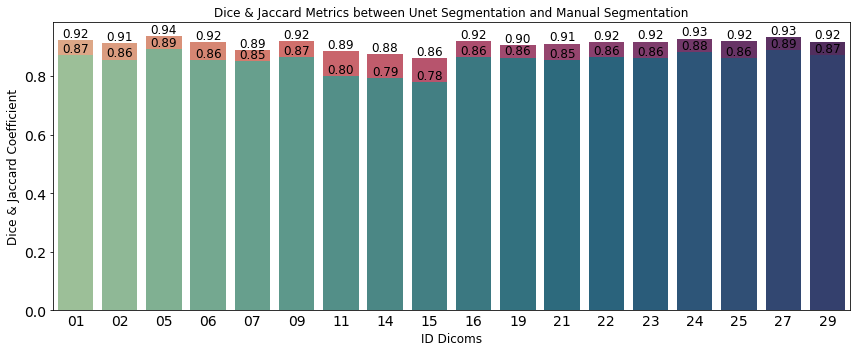

In [6]:
import seaborn as sns

def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y()+0.01 + p.get_height()
                value = '{:.2f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center", fontsize=12) 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = p.get_width()
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
        
valDicom = []
valMetric_dice = []
valMetric_jaccard = []
for metric in metrics:
    valDicom.append(metric[0])
    valMetric_dice.append(metric[1])
    valMetric_jaccard.append(metric[2])
dataMetrics = {"dicom": valDicom, "dice": valMetric_dice, "jaccard": valMetric_jaccard}
#data
dfMetric = pd.DataFrame(dataMetrics)
#dfOrderMetric = dfMetric.sort_values(by=['dice_metrics'])

plt.figure(figsize=(12,5))
ax = sns.barplot(x="dicom", y="dice", data=dfMetric,palette="flare")
ax = sns.barplot(x="dicom", y="jaccard", data=dfMetric,palette="crest")
plt.setp(ax.get_xticklabels(), rotation=0)
ax.tick_params(labelsize=14)
ax.tick_params(length=0, axis='x')
ax.set_ylabel("Dice & Jaccard Coefficient", fontsize=12)
ax.set_xlabel("ID Dicoms", fontsize=12)
ax.set_title("Dice & Jaccard Metrics between Unet Segmentation and Manual Segmentation")
show_values_on_bars(ax, "v", 0.3)
plt.tight_layout()
plt.show()
